In [4]:
# Compute deconvolution
from scipy.io import loadmat
from suite2p.extraction import dcnv
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import array
import importlib
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
# get path
mouse = 'NN9'
date = '210429'
data_path = 'D:/2p_data/scan/'+mouse+'/'+date+'_'+mouse+'/suite2p_plane_1/suite2p/plane0/'

In [3]:
importlib.reload(dcnv)
# compute deconvolution
tau = 1.5 # timescale of indicator
fs = 10.42 # sampling rate in Hz
neucoeff = 0.7 # neuropil coefficient
# for computing and subtracting baseline
baseline = 'maximin' # take the running max of the running min after smoothing with gaussian
sig_baseline = 10.0 # in bins, standard deviation of gaussian with which to smooth
win_baseline = 60.0 # in seconds, window in which to compute max/min filters
ops = {'tau': tau, 'fs': fs, 'neucoeff': neucoeff,
       'baseline': baseline, 'sig_baseline': sig_baseline, 'win_baseline': win_baseline, 'prctile_baseline': 8.0, 'batch_size': 10}
# load traces and subtract neuropil
F = np.load(data_path+'F.npy')
Fneu = np.load(data_path+'Fneu.npy')
Fc = F - ops['neucoeff'] * Fneu
# baseline operation
Fc = dcnv.preprocess(
     F=Fc,
     baseline=ops['baseline'],
     win_baseline=ops['win_baseline'],
     sig_baseline=ops['sig_baseline'],
     fs=ops['fs'],
     prctile_baseline=ops['prctile_baseline']
 )
# get spikes
spks = dcnv.oasis(F=Fc, batch_size=ops['batch_size'], tau=ops['tau'], fs=ops['fs'])

KeyboardInterrupt: 

In [9]:
# load traces 
F = np.load(data_path+'F.npy')
Fneu = np.load(data_path+'Fneu.npy')
Fc = F -  ops['neucoeff']*Fneu
spks = np.load(data_path+'spks.npy')

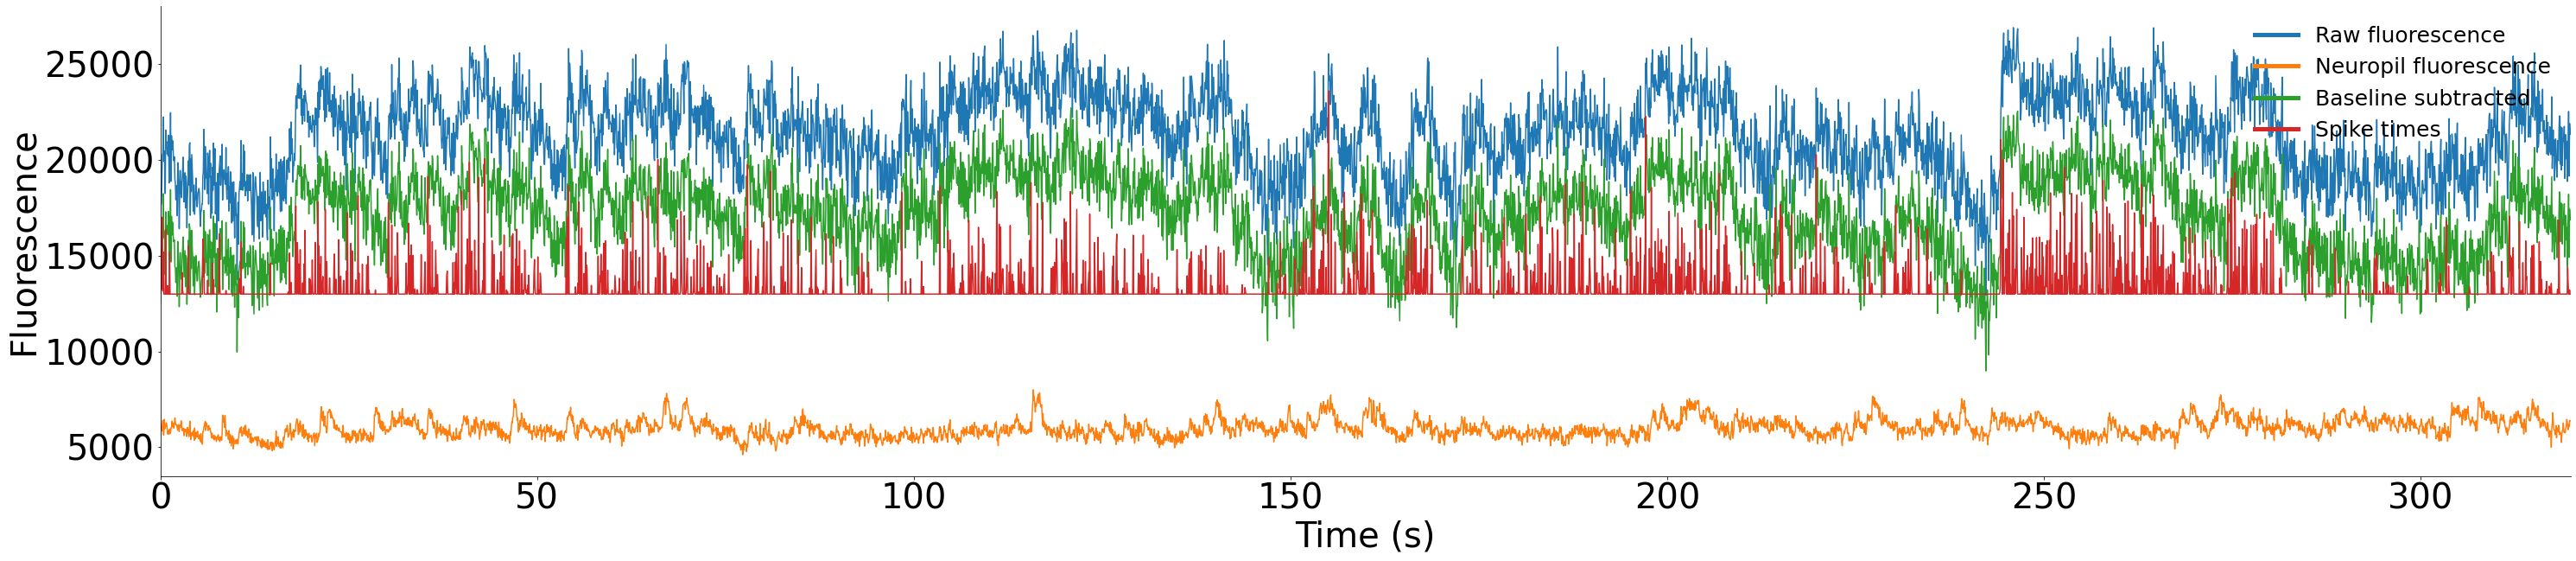

In [10]:
# look at example cell
cell = 0
frames = 5000
ax_dims = (50,10)
fig, ax = plt.subplots(figsize=ax_dims)
x = list(range(0,frames))
x = [i / 15.63 for i in x]
plt.plot(x,F[cell,0:frames]) # cell fluorescence
plt.plot(x,Fneu[cell,0:frames]) # neuropil
plt.plot(x,Fc[cell,0:frames]) # baseline subtracted
plt.plot(x,spks[cell,0:frames]*3+13000) # calcium events
plt.xlim(0,frames/15.63)
plt.xlabel('Time (s)', fontsize=40)
plt.ylabel('Fluorescence', fontsize=40)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
leg = plt.legend(('Raw fluorescence', 'Neuropil fluorescence', 'Baseline subtracted', 'Spike times'), fontsize = 25, frameon=False)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5)
ax.tick_params(labelsize=40)

In [16]:
import random
from numpy import exp
spks_c = np.zeros((len(spks), len(spks[0])))
times = list(range(0,len(data)))
s = np.zeros(len(spks))
decay = 1.5 * 10.42  # decay to 1/e after this time                                                       
for t in range(0, len(times)):
    s += spks[:, t]
    s = s * exp(-1/decay)
    spks_c[:, t] = s

In [128]:
b = 20
a = 80
f_cue = np.zeros((len(Fc), b+a))
spks_c_cue = np.zeros((len(Fc), b+a))
for i in range(0, len(onsets)):
    f_cue = f_cue + Fc[:, onsets[i][0]-b:onsets[i][0]+a]
    spks_c_cue = spks_c_cue + spks_c[:, onsets[i][0]-b:onsets[i][0]+a]
f_cue = f_cue / len(onsets)
spks_c_cue = spks_c_cue / len(onsets)
f_cue = (np.mean(f_cue[:,b:b+a], axis=1) - np.mean(f_cue[:,0:b], axis=1))  / np.mean(f_cue[:,0:b], axis=1)
spks_c_cue = (np.mean(spks_c_cue[:,b:b+a], axis=1) - np.mean(spks_c_cue[:,0:b], axis=1)) / np.mean(spks_c_cue[:,0:b], axis=1)
diff = f_cue - spks_c_cue

(-4.0, 4.0)

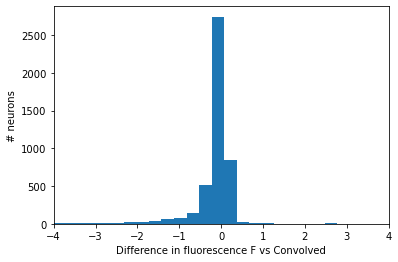

In [129]:
fig = plt.figure()
fig.patch.set_facecolor('w')
plt.hist(diff, bins=1000)
plt.ylabel('# neurons')
plt.xlabel('Difference in fluorescence F vs Convolved')
plt.xlim(-4, 4)